In [22]:
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
def compute_nucleotide_counts_and_statistics(bam_file_path, reference_fai_path, position=73):
    try:
        # Open the BAM file
        bamfile = pysam.AlignmentFile(bam_file_path, "rb")

        # Load the reference FAI file
        reference = pysam.FastaFile(reference_fai_path)

        # Convert position to 0-based index
        zero_based_position = position - 1

        # Retrieve the reference nucleotide at the specified position
        reference_nucleotide = reference.fetch(reference.references[0], zero_based_position,
                                               zero_based_position + 1).upper()

        # Initialize counters for forward strand
        total_reads_forward = 0
        nucleotide_counts_forward = {'A': 0, 'C': 0, 'G': 0, 'T': 0}

        # Initialize counters for reverse strand
        total_reads_reverse = 0
        nucleotide_counts_reverse = {'A': 0, 'C': 0, 'G': 0, 'T': 0}

        # Initialize counters for overall statistics
        total_reads = 0
        total_length = 0
        total_quality = 0

        # Lists to hold read lengths and quality scores for visualization
        read_lengths = []
        quality_scores = []

        # Iterate through each read in the BAM file
        for read in bamfile:
            if not read.is_unmapped:
                total_reads += 1
                read_lengths.append(read.query_length)
                total_length += read.query_length

                if read.query_qualities:
                    avg_quality = sum(read.query_qualities) / read.query_length
                    quality_scores.append(avg_quality)
                    total_quality += avg_quality

                # Check if the read covers the position of interest
                if read.reference_start <= zero_based_position < read.reference_end:
                    read_pos = zero_based_position - read.reference_start  # 0-based index for the read sequence
                    if read_pos < len(read.query_sequence):
                        read_base = read.query_sequence[read_pos].upper()
                        if read.is_reverse:
                            total_reads_reverse += 1
                            nucleotide_counts_reverse[read_base] = nucleotide_counts_reverse.get(read_base, 0) + 1
                        else:
                            total_reads_forward += 1
                            nucleotide_counts_forward[read_base] = nucleotide_counts_forward.get(read_base, 0) + 1

        # Calculate average read length and average quality score
        avg_read_length = total_length / total_reads if total_reads > 0 else 0
        avg_quality_score = total_quality / total_reads if total_quality > 0 else 0

        # Print the results
        print(f"Total reads: {total_reads}")
        print(f"Average read length: {avg_read_length:.2f}")
        print(f"Average quality score: {avg_quality_score:.2f}")

        print(f"Forward strand: Total reads at position {position}: {total_reads_forward}")
        print(f"Forward strand: Nucleotide counts at position {position}: {nucleotide_counts_forward}")

        print(f"Reverse strand: Total reads at position {position}: {total_reads_reverse}")
        print(f"Reverse strand: Nucleotide counts at position {position}: {nucleotide_counts_reverse}")

        # Print the reference nucleotide at the specified position
        print(f"Reference nucleotide at position {position}: {reference_nucleotide}")

    except Exception as e:
        print(f"An error occurred: {e}")

In [24]:
def plot_base_quality_heatmap(bam_file_path):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    max_read_length = 0
    quality_matrix = []

    for read in bamfile:
        if not read.is_unmapped and read.query_qualities:
            max_read_length = max(max_read_length, read.query_length)
            quality_matrix.append(np.array(read.query_qualities))

    # Check if quality_matrix is not empty
    if not quality_matrix:
        print("No valid quality scores found in the BAM file.")
        return

    # Pad the quality scores to the maximum read length
    padded_quality_matrix = [np.pad(q, (0, max_read_length - len(q)), 'constant', constant_values=0) for q in quality_matrix]

    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array(padded_quality_matrix), cmap="viridis", cbar_kws={'label': 'Base Quality'})
    plt.title('Base Quality Heatmap')
    plt.xlabel('Position in Read')
    plt.ylabel('Read Index')
    plt.show()

In [25]:
def plot_coverage(bam_file_path, reference_fai_path):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    reference = pysam.FastaFile(reference_fai_path)
    reference_length = reference.get_reference_length(reference.references[0])
    coverage = np.zeros(reference_length)

    for read in bamfile:
        if not read.is_unmapped:
            start = read.reference_start
            end = read.reference_end
            coverage[start:end] += 1

    plt.figure(figsize=(12, 6))
    plt.plot(coverage)
    plt.title('Coverage Plot')
    plt.xlabel('Position in Reference')
    plt.ylabel('Coverage Depth')
    plt.show()

In [26]:
def plot_gc_content_distribution(bam_file_path):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    gc_content = []

    for read in bamfile:
        if not read.is_unmapped:
            seq = read.query_sequence.upper()
            gc_count = seq.count('G') + seq.count('C')
            gc_content.append(gc_count / len(seq))

    plt.figure(figsize=(12, 6))
    sns.histplot(gc_content, bins=50, kde=True)
    plt.title('GC Content Distribution')
    plt.xlabel('GC Content')
    plt.ylabel('Frequency')
    plt.show()

In [27]:
def plot_read_vs_reference_length(bam_file_path):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    read_lengths = []
    reference_lengths = []

    for read in bamfile:
        if not read.is_unmapped:
            read_lengths.append(read.query_length)
            reference_lengths.append(read.reference_length)

    bamfile.close()

    plt.figure(figsize=(12, 6))
    plt.scatter(reference_lengths, read_lengths, alpha=0.5)
    plt.title('Read Alignment Length vs. Reference Length')
    plt.xlabel('Reference Length')
    plt.ylabel('Read Length')
    plt.show()

In [28]:
def plot_mismatch_rate(bam_file_path):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    mismatch_rates = []

    for read in bamfile:
        if not read.is_unmapped:
            mismatches = sum([tag[1] for tag in read.get_tags() if tag[0] == 'NM'])
            mismatch_rates.append(mismatches / read.query_length)

    bamfile.close()

    plt.figure(figsize=(12, 6))
    sns.histplot(mismatch_rates, bins=50, kde=True)
    plt.title('Mismatch Rate Distribution')
    plt.xlabel('Mismatch Rate')
    plt.ylabel('Frequency')
    plt.show()

In [29]:
def find_c_sites(reference_fai_path):
    reference = pysam.FastaFile(reference_fai_path)
    sequence = reference.fetch(reference.references[0])
    c_sites = [i for i in range(len(sequence) - 1) if sequence[i:i + 1] == 'C']
    reference.close()
    return c_sites

def find_cg_sites(reference_fai_path):
    reference = pysam.FastaFile(reference_fai_path)
    sequence = reference.fetch(reference.references[0])
    cg_sites = [i for i in range(len(sequence) - 1) if sequence[i:i + 2] == 'CG']
    reference.close()
    return cg_sites

In [30]:
def compute_coverage_at_positions_all(bam_file_path, positions):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    coverage = np.zeros(max(positions) + 1)

    for read in bamfile:
        if not read.is_unmapped:
            start = read.reference_start
            end = read.reference_end
            coverage[start:end] += 1

    bamfile.close()
    return coverage

In [31]:
def plot_coverage_at_c_sites(bam_file_path, reference_fai_path):
    c_sites = find_c_sites(reference_fai_path)
    coverage = compute_coverage_at_positions_all(bam_file_path, c_sites)

    c_coverage = [coverage[pos] for pos in c_sites]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(c_sites)), c_coverage, tick_label=c_sites)
    plt.title('Coverage at C Sites')
    plt.xlabel('Position in Reference')
    plt.ylabel('Coverage Depth')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

In [32]:
def plot_coverage_at_cg_sites(bam_file_path, reference_fai_path):
    cg_sites = find_cg_sites(reference_fai_path)
    coverage = compute_coverage_at_positions_all(bam_file_path, cg_sites)

    cg_coverage = [coverage[pos] for pos in cg_sites]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(cg_sites)), cg_coverage, tick_label=cg_sites)
    plt.title('Coverage at CG Sites')
    plt.xlabel('Position in Reference')
    plt.ylabel('Coverage Depth')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()

In [33]:
def compute_coverage_at_positions(bam_file_path, positions):
    if not positions:
        return np.array([]), np.array([])

    max_position = max(positions)
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    coverage_forward = np.zeros(max_position + 1)
    coverage_reverse = np.zeros(max_position + 1)

    for read in bamfile:
        if not read.is_unmapped:
            start = read.reference_start
            end = read.reference_end
            if read.is_reverse:
                coverage_reverse[start:end] += 1
            else:
                coverage_forward[start:end] += 1

    bamfile.close()
    return coverage_forward, coverage_reverse

In [34]:
def plot_coverage_at_cg_sites_by_fwd_rvs(bam_file_path, reference_fai_path):
    cg_sites = find_cg_sites(reference_fai_path)

    if not cg_sites:
        print("No CG sites found in the reference.")
        return

    coverage_forward, coverage_reverse = compute_coverage_at_positions(bam_file_path, cg_sites)

    # Check if there are any valid CG sites within the coverage range
    if coverage_forward.size == 0 or coverage_reverse.size == 0:
        print("No valid coverage data found.")
        return

    cg_coverage_forward = [coverage_forward[pos] for pos in cg_sites if pos < len(coverage_forward)]
    cg_coverage_reverse = [coverage_reverse[pos] for pos in cg_sites if pos < len(coverage_reverse)]

    plt.figure(figsize=(12, 6))
    bar_width = 0.4
    indices = np.arange(len(cg_sites))

    plt.bar(indices - bar_width / 2, cg_coverage_forward, bar_width, label='Forward Strand')
    plt.bar(indices + bar_width / 2, cg_coverage_reverse, bar_width, label='Reverse Strand')

    plt.xticks(indices, cg_sites, rotation=90)
    plt.title('Coverage at CG Sites by Strand')
    plt.xlabel('Position in Reference')
    plt.ylabel('Coverage Depth')
    plt.legend()
    plt.show()

In [35]:
def plot_coverage_at_c_sites_by_fwd_rvs(bam_file_path, reference_fai_path):
    c_sites = find_c_sites(reference_fai_path)

    coverage_forward, coverage_reverse = compute_coverage_at_positions(bam_file_path, c_sites)

    # Check if there are any valid CG sites within the coverage range
    if coverage_forward.size == 0 or coverage_reverse.size == 0:
        print("No valid coverage data found.")
        return

    c_coverage_forward = [coverage_forward[pos] for pos in c_sites if pos < len(coverage_forward)]
    c_coverage_reverse = [coverage_reverse[pos] for pos in c_sites if pos < len(coverage_reverse)]

    plt.figure(figsize=(12, 6))
    bar_width = 0.4
    indices = np.arange(len(c_sites))

    plt.bar(indices - bar_width / 2, c_coverage_forward, bar_width, label='Forward Strand')
    plt.bar(indices + bar_width / 2, c_coverage_reverse, bar_width, label='Reverse Strand')

    plt.xticks(indices, c_sites, rotation=90)
    plt.title('Coverage at C Sites by Strand')
    plt.xlabel('Position in Reference')
    plt.ylabel('Coverage Depth')
    plt.legend()
    plt.show()

In [36]:
bam = "/Users/nguyec27/Methylation/MinION/200 uM SAM - 1st Cycle Spike-In/FAZ30104_pass_1e7d0389_054cbd2d_0.bam"
reference = "/Users/nguyec27/Methylation/MinION/Reference/ClaSau150.fa"

Total reads: 2492
Average read length: 172.01
Average quality score: 22.13
Forward strand: Total reads at position 74: 1384
Forward strand: Nucleotide counts at position 74: {'A': 219, 'C': 464, 'G': 432, 'T': 269}
Reverse strand: Total reads at position 74: 968
Reverse strand: Nucleotide counts at position 74: {'A': 265, 'C': 199, 'G': 172, 'T': 332}
Reference nucleotide at position 74: C


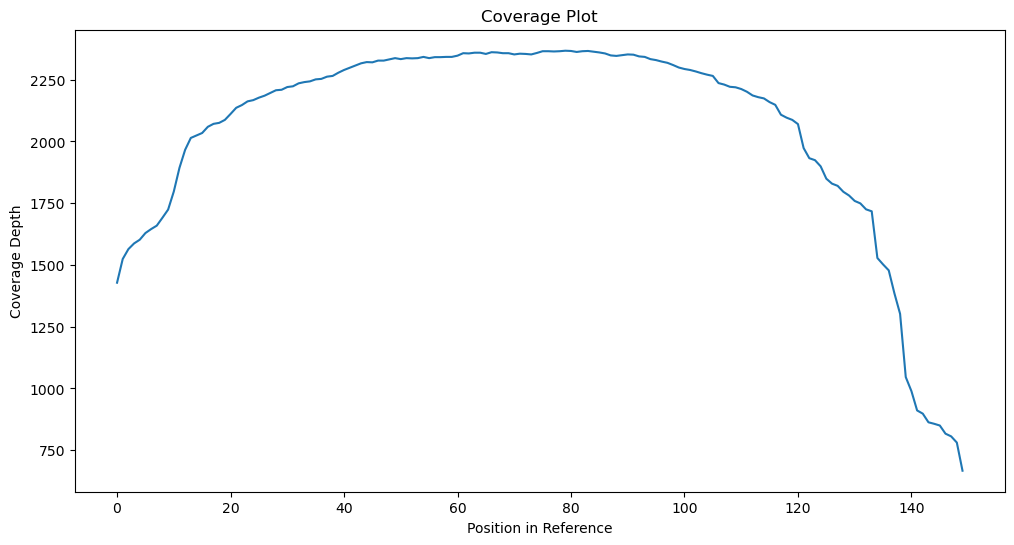

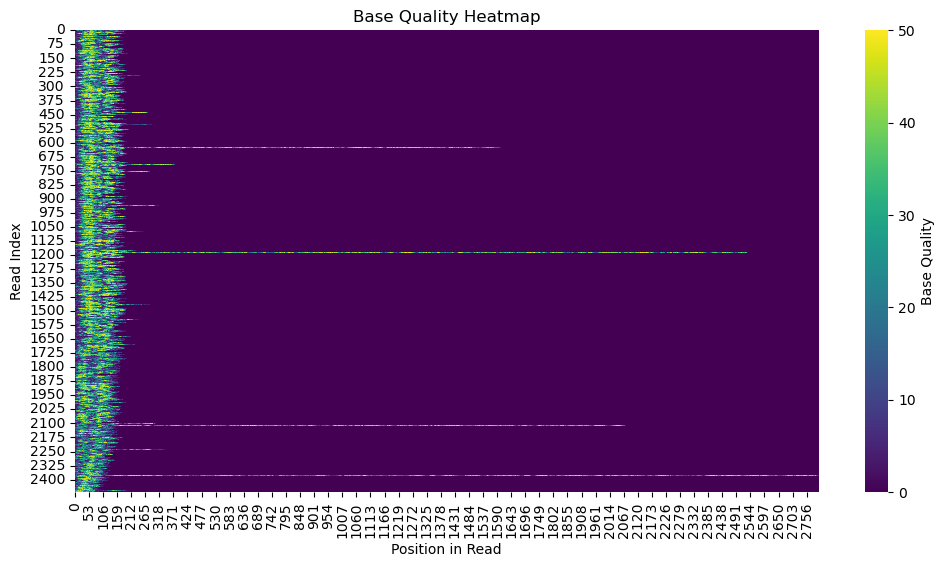

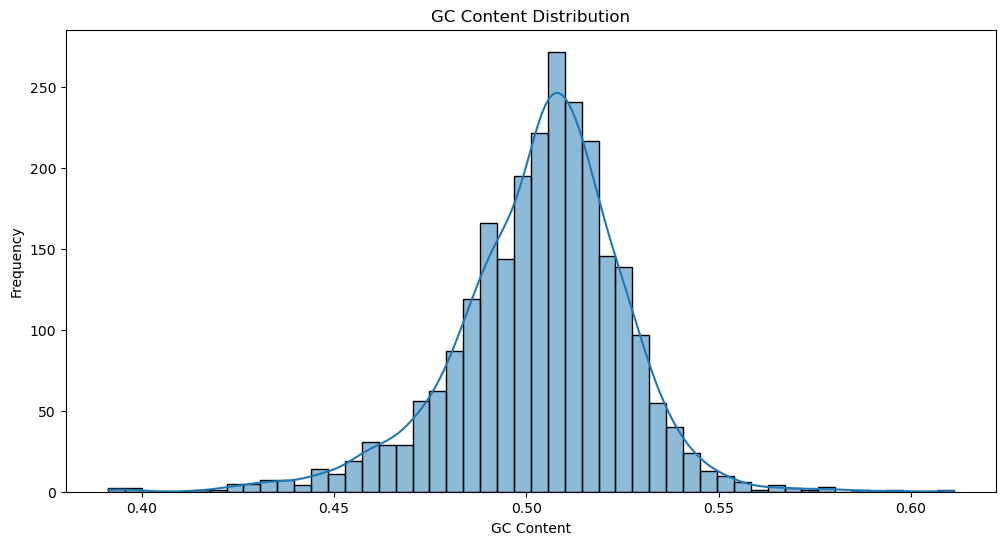

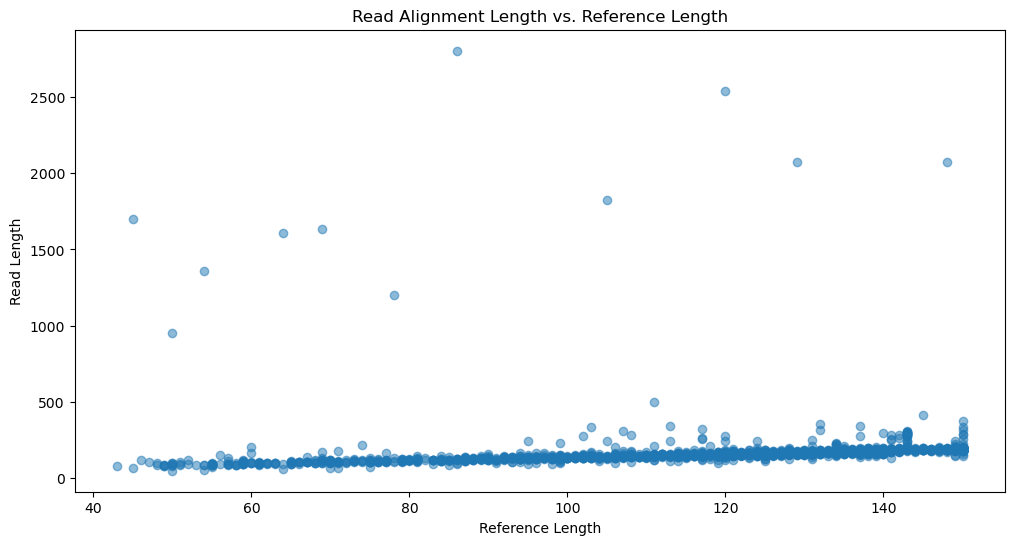

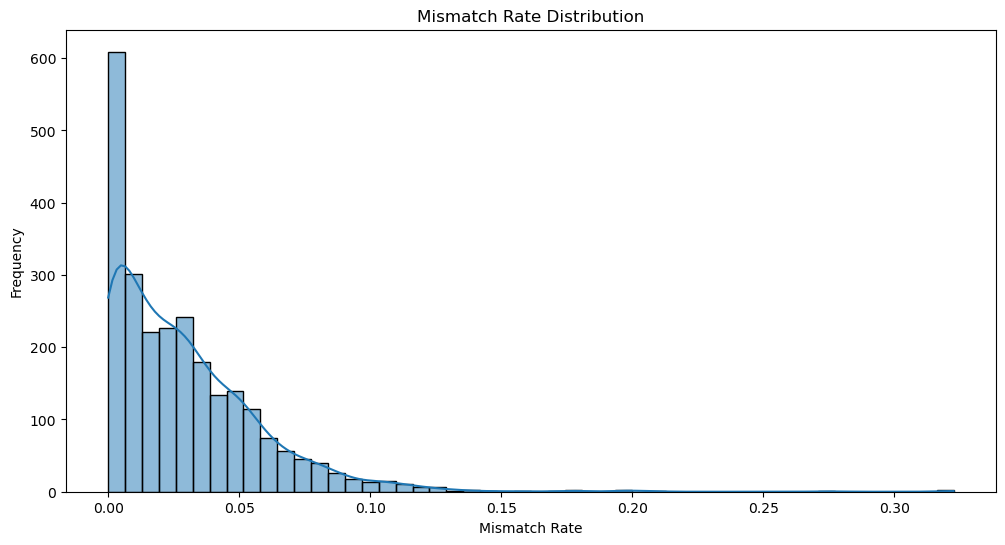

In [37]:
compute_nucleotide_counts_and_statistics(bam, reference, position=74)
plot_coverage(bam, reference)
plot_base_quality_heatmap(bam)
plot_gc_content_distribution(bam)
plot_read_vs_reference_length(bam)
plot_mismatch_rate(bam)

In [38]:
def extract_q_scores_and_read_lengths(bam_file_path, min_read_length=None, max_read_length=None):
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    q_scores = []
    read_lengths = []

    for read in bamfile:
        if not read.is_unmapped:
            read_length = read.query_length
            if ((min_read_length is None or read_length >= min_read_length) and
                (max_read_length is None or read_length <= max_read_length)):
                if read.query_qualities is not None:
                    q_scores.extend(read.query_qualities)
                read_lengths.append(read_length)

    bamfile.close()
    return q_scores, read_lengths

def plot_q_score_distribution(q_scores):
    q_score_counts = np.bincount(q_scores)
    q_scores_range = np.arange(len(q_score_counts))

    plt.figure(figsize=(12, 6))
    plt.bar(q_scores_range, q_score_counts, edgecolor='black', alpha=0.7)
    plt.title('Q Score Distribution')
    plt.xlabel('Q Score')
    plt.ylabel('Number of Reads')
    plt.xticks(range(0, 51, 2))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_read_length_distribution(read_lengths):
    plt.figure(figsize=(12, 6))
    plt.hist(read_lengths, bins=range(0, max(read_lengths) + 1, 10), edgecolor='black', alpha=0.7)
    plt.title('Read Length Distribution')
    plt.xlabel('Read Length')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



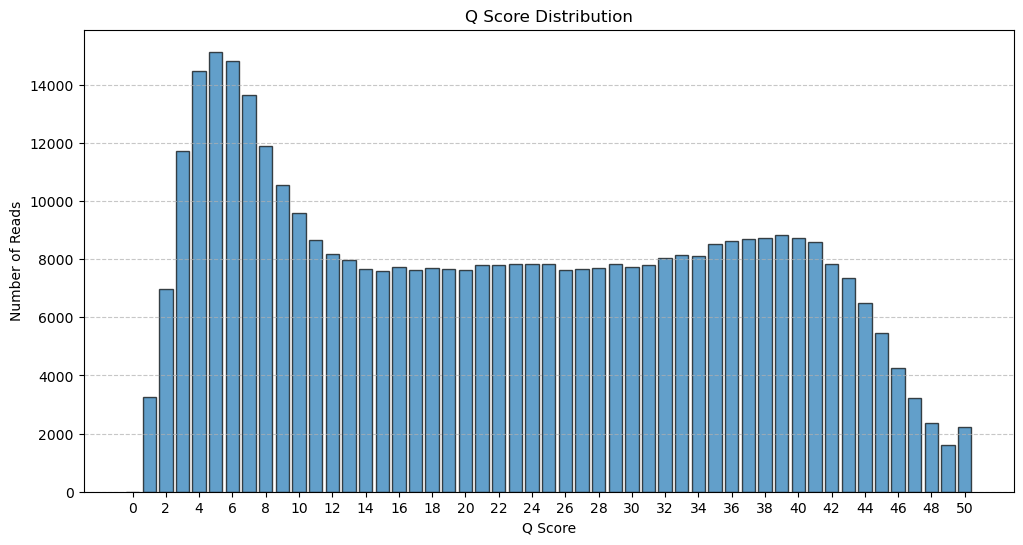

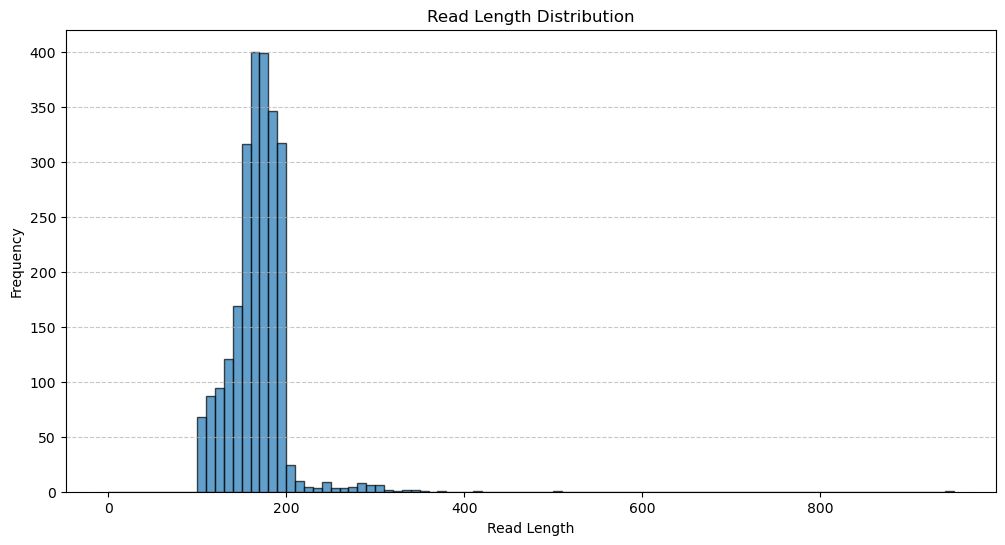

In [39]:
min_read_length = 100  # Example minimum read length to include
max_read_length = 1000  # Example maximum read length to include
q_scores, read_lengths = extract_q_scores_and_read_lengths(bam, min_read_length, max_read_length)
plot_q_score_distribution(q_scores)
plot_read_length_distribution(read_lengths)

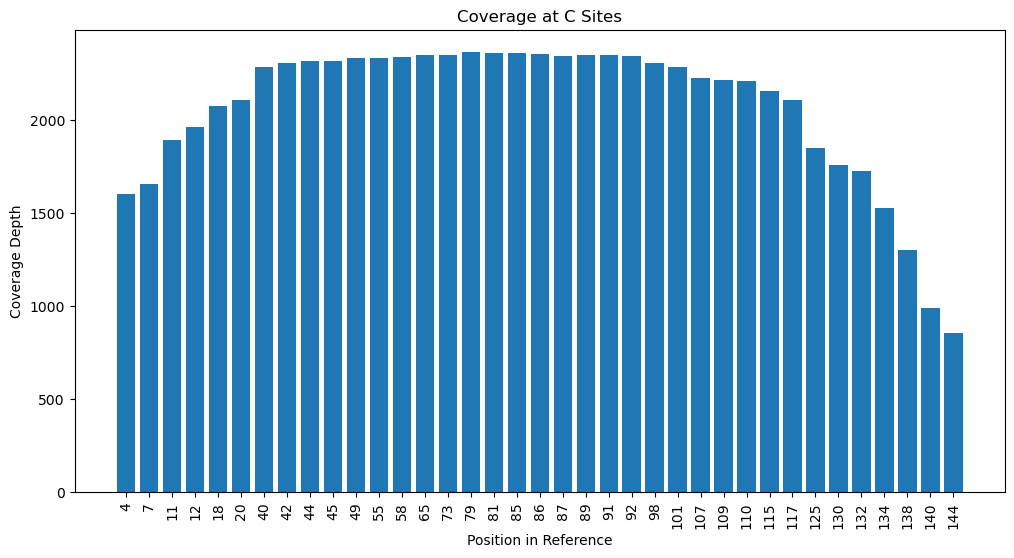

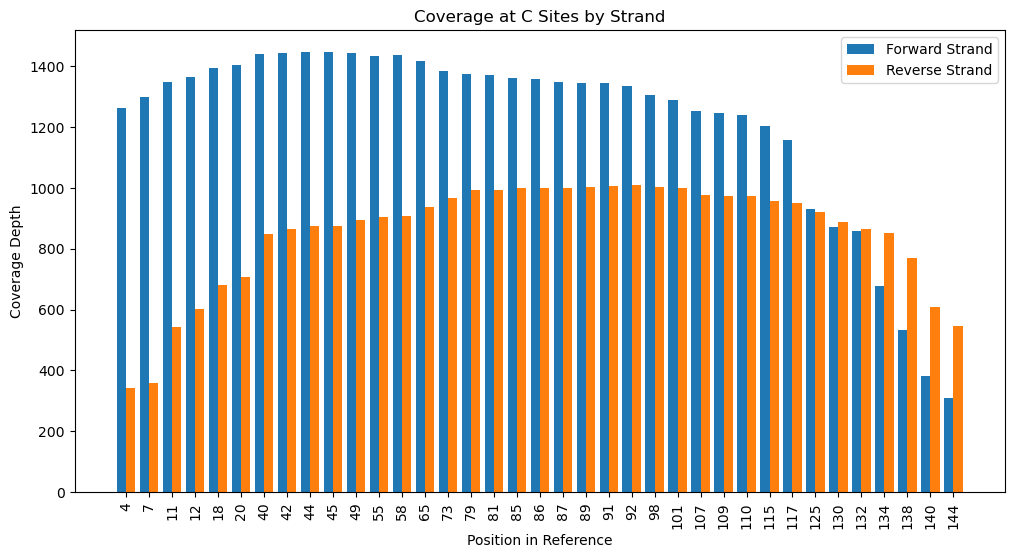

In [40]:
plot_coverage_at_c_sites(bam, reference)
plot_coverage_at_c_sites_by_fwd_rvs(bam, reference)

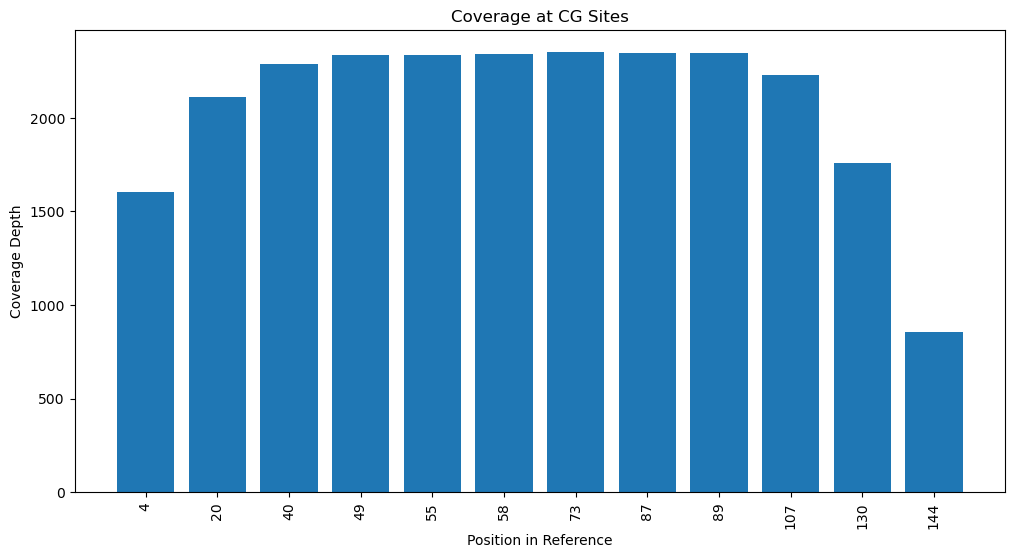

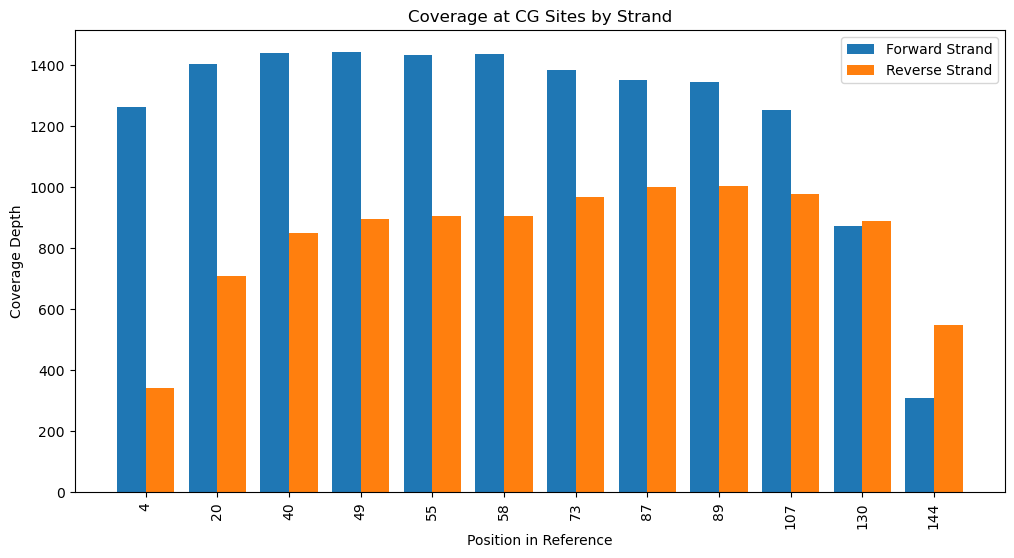

In [41]:
plot_coverage_at_cg_sites(bam, reference)
plot_coverage_at_cg_sites_by_fwd_rvs(bam, reference)

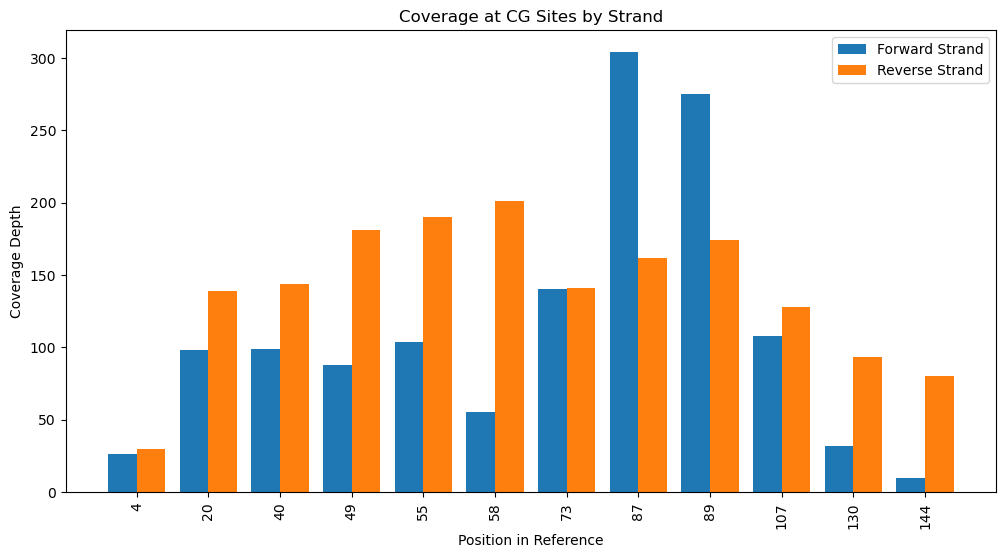

In [42]:

import pysam
import numpy as np
import matplotlib.pyplot as plt

def find_cg_sites(reference_fai_path):
    reference = pysam.FastaFile(reference_fai_path)
    sequence = reference.fetch(reference.references[0])
    cg_sites = [i for i in range(len(sequence) - 1) if sequence[i:i + 2] == 'CG']
    reference.close()
    return cg_sites

def compute_coverage_at_positions(bam_file_path, reference_fai_path, cg_sites):
    if not cg_sites:
        return np.array([]), np.array([])

    max_position = max(cg_sites)
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    reference = pysam.FastaFile(reference_fai_path)
    reference_sequence = reference.fetch(reference.references[0])

    coverage_forward = np.zeros(max_position + 1)
    coverage_reverse = np.zeros(max_position + 1)

    for read in bamfile:
        if not read.is_unmapped:
            read_sequence = read.query_sequence
            read_start = read.reference_start
            read_end = read.reference_end
            if read.query_qualities is not None and read_start < len(reference_sequence) and read_end <= len(reference_sequence):
                for cg_site in cg_sites:
                    if read_start <= cg_site < read_end:
                        read_pos = cg_site - read_start
                        if read_sequence[read_pos:read_pos + 2] == 'CG':
                            if read.is_reverse:
                                coverage_reverse[cg_site] += 1
                            else:
                                coverage_forward[cg_site] += 1

    bamfile.close()
    reference.close()
    return coverage_forward, coverage_reverse

def plot_coverage_at_cg_sites_by_fwd_rvs(bam_file_path, reference_fai_path):
    cg_sites = find_cg_sites(reference_fai_path)
    
    if not cg_sites:
        print("No CG sites found in the reference.")
        return

    coverage_forward, coverage_reverse = compute_coverage_at_positions(bam_file_path, reference_fai_path, cg_sites)

    # Check if there are any valid CG sites within the coverage range
    if coverage_forward.size == 0 or coverage_reverse.size == 0:
        print("No valid coverage data found.")
        return

    cg_coverage_forward = [coverage_forward[pos] for pos in cg_sites if pos < len(coverage_forward)]
    cg_coverage_reverse = [coverage_reverse[pos] for pos in cg_sites if pos < len(coverage_reverse)]

    plt.figure(figsize=(12, 6))
    bar_width = 0.4
    indices = np.arange(len(cg_sites))
    
    plt.bar(indices - bar_width / 2, cg_coverage_forward, bar_width, label='Forward Strand')
    plt.bar(indices + bar_width / 2, cg_coverage_reverse, bar_width, label='Reverse Strand')
    
    plt.xticks(indices, cg_sites, rotation=90)
    plt.title('Coverage at CG Sites by Strand')
    plt.xlabel('Position in Reference')
    plt.ylabel('Coverage Depth')
    plt.legend()
    plt.show()

# Example usage
bam = "/Users/nguyec27/Methylation/MinION/200 uM SAM - 1st Cycle Spike-In/FAZ30104_pass_1e7d0389_054cbd2d_0.bam"
reference = "/Users/nguyec27/Methylation/MinION/Reference/ClaSau150.fa"
plot_coverage_at_cg_sites_by_fwd_rvs(bam, reference)
